In [2]:
import os, sys

sys.path.append('/home/ubuntu/crypto_prediction/git/crypto_prediction_ml_dl/script')

import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from datetime import datetime
from trino_operations import trino_operator
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()

In [2]:
def create_dataframe_from_hive_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
):
    """Load data form Hive mart table

        Args:
            target_schema: hive schema name
            target_table: hive table name
            target_columns: column name list to load
            target_symbol: symbol name (e.g., BTC_USDT)
            column_prefix: prefix name for each column

        Returns:
            data frame
    """
    query = f"""
    select
        {target_columns}
    from 
        hive.{target_schema}.{target_table}
    where
        id = '{target_symbol}'
    order by dt
    """

    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    target_columns_list = [
        column_prefix + column.strip() for column in target_columns.strip().split(",")
    ]

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=target_columns_list
    )

    return indicators_raw_df

In [3]:
########################
# Load BTC_USDT OHLC and indicators
########################
target_schema = "crypto_raw"
target_table = "crypto_indicator_day"
target_symbol = "BTC_USDT"
column_prefix = "btc_"
target_columns = """
    id,
    dt,
    low,
    high,
    open,
    close,
    volume,
    macd,
    macd_single,
    rsi,
    bollinger_bands_sma,
    bollinger_bands_lower_band,
    bollinger_bands_upper_band,
    obv,
    obv_sma,
    ichimoku_chikou_span,
    ichimoku_kijun_sen,
    ichimoku_tenkan_sen,
    ichimoku_senkou_span_a,
    ichimoku_senkou_span_b,
    stoch_oscillator,
    stoch_signal,
    stoch_percent_j,
    aroon_up,
    aroon_down,
    aroon_oscillator,
    sma5,
    sma10,
    sma30,
    ema5,
    ema10,
    ema30
    """

btc_raw_df = create_dataframe_from_hive_mart_table(
    target_schema, target_table, target_columns, target_symbol, column_prefix
)

btc_raw_df.tail()

,btc_id,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,...,btc_stoch_percent_j,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30
1062,BTC_USDT,2023-09-28,26339.60,27290.24,26369.34,27017.99,51378024.0,-11.275443,-66.689490,57.244520,...,41.619076,64.0,32.0,32.0,26430.867,26618.682,26282.445,26586.640,26535.283,26581.174
1063,BTC_USDT,2023-09-29,26704.52,27224.08,27019.20,26906.87,50639060.0,20.406696,-49.270256,55.375390,...,70.215670,60.0,28.0,32.0,26562.945,26589.324,26269.400,26693.383,26602.844,26602.186
1064,BTC_USDT,2023-09-30,26888.80,27086.59,26903.78,26963.34,31372394.0,49.501114,-29.515982,56.158817,...,89.503290,56.0,24.0,32.0,26694.877,26574.360,26303.664,26783.370,26668.389,26625.486
1065,BTC_USDT,2023-10-01,26950.96,28023.42,26962.75,27963.19,28923746.0,151.491850,6.685586,67.154010,...,95.700750,100.0,20.0,80.0,27043.760,26713.297,26375.523,27176.643,26903.807,26711.790
1066,BTC_USDT,2023-10-02,27883.68,28034.81,27975.06,27922.50,1756101.5,226.426850,50.633840,66.423920,...,106.837750,100.0,16.0,84.0,27354.777,26847.742,26443.932,27425.262,27089.023,26789.900


There are 32 columns in the btc_raw_df above.
- 1 id column
- 1 date type column
- 5 columns for OHLC and volume data
- 25 indicator columns which are calculated from OHLC and volume data

Add a target column to predict
- Predicting "close" value after N days.
- At this time, N will be 1.

In [4]:
####################################
# Create Dataset with target value
####################################

# Check if all "date" exist in the dataframe.
first_dt = str(btc_raw_df.iloc[0]['btc_dt'])
last_dt = str(btc_raw_df.iloc[-1]['btc_dt'])
desired_date_range = pd.date_range(start=first_dt, end=last_dt, freq='D')
all_dates_exist = all(str(date)[:11].strip() == str(btc_raw_df.iloc[i]['btc_dt']).strip() for i,date in enumerate(desired_date_range))
if all_dates_exist:
    print("All dates exist in the DataFrame's index.")
else:
    print("Not all dates exist in the DataFrame's index.")

btc_df_with_target = btc_raw_df

# Create target value to predict
# Predict the "close" value after N days.
predicting_days = 1
target = btc_raw_df['btc_close'].shift(-predicting_days)
btc_df_with_target['target'] = target

btc_df_with_target.tail()

All dates exist in the DataFrame's index.


,btc_id,btc_dt,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,...,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30,target
1062,BTC_USDT,2023-09-28,26339.60,27290.24,26369.34,27017.99,51378024.0,-11.275443,-66.689490,57.244520,...,64.0,32.0,32.0,26430.867,26618.682,26282.445,26586.640,26535.283,26581.174,26906.87
1063,BTC_USDT,2023-09-29,26704.52,27224.08,27019.20,26906.87,50639060.0,20.406696,-49.270256,55.375390,...,60.0,28.0,32.0,26562.945,26589.324,26269.400,26693.383,26602.844,26602.186,26963.34
1064,BTC_USDT,2023-09-30,26888.80,27086.59,26903.78,26963.34,31372394.0,49.501114,-29.515982,56.158817,...,56.0,24.0,32.0,26694.877,26574.360,26303.664,26783.370,26668.389,26625.486,27963.19
1065,BTC_USDT,2023-10-01,26950.96,28023.42,26962.75,27963.19,28923746.0,151.491850,6.685586,67.154010,...,100.0,20.0,80.0,27043.760,26713.297,26375.523,27176.643,26903.807,26711.790,27922.50
1066,BTC_USDT,2023-10-02,27883.68,28034.81,27975.06,27922.50,1756101.5,226.426850,50.633840,66.423920,...,100.0,16.0,84.0,27354.777,26847.742,26443.932,27425.262,27089.023,26789.900,NaN


In [5]:
# show the distirbution of data in each of these columns.
btc_df_with_target.describe()

,btc_low,btc_high,btc_open,btc_close,btc_volume,btc_macd,btc_macd_single,btc_rsi,btc_bollinger_bands_sma,btc_bollinger_bands_lower_band,...,btc_aroon_up,btc_aroon_down,btc_aroon_oscillator,btc_sma5,btc_sma10,btc_sma30,btc_ema5,btc_ema10,btc_ema30,target
count,1066.000000,1066.000000,1066.000000,1066.000000,1.066000e+03,1041.000000,1032.000000,1052.000000,1047.000000,1047.000000,...,924.000000,894.000000,1026.000000,1062.000000,1057.000000,1037.000000,1062.000000,1057.000000,1037.000000,1065.000000
mean,32826.046229,34626.848555,33773.291576,33787.217598,2.777888e+07,73.721223,68.633556,50.989498,34019.821183,30075.727092,...,58.645022,52.814318,6.795322,33836.464872,33898.052491,34138.399995,33836.070588,33896.779586,34130.282684,33806.034469
std,12658.033166,13518.044693,13136.260743,13123.293840,3.611676e+07,1603.666902,1530.581849,13.634494,12871.407899,11395.316856,...,32.231280,31.601933,59.544409,13064.882674,13001.047997,12746.849538,13038.446493,12944.121085,12549.177161,13115.064034
min,13207.510000,13825.000000,13556.050000,13558.840000,1.945060e+03,-5075.484400,-4436.556600,17.769420,15821.848000,13072.249000,...,4.000000,4.000000,-100.000000,14208.216000,14752.828000,16656.650000,14208.216000,14752.828000,16656.650000,13558.840000
25%,22342.860000,23296.655000,22806.260000,22853.692500,4.762108e+06,-812.019650,-746.992050,41.086281,22949.631000,19591.531000,...,28.000000,24.000000,-48.000000,22908.197250,22840.137000,23008.451000,22812.134500,22794.790000,22823.713000,22910.760000
50%,29491.970000,30567.200000,30083.850000,30086.910000,1.459862e+07,-92.201950,-102.544105,49.156402,30023.232000,27917.146000,...,64.000000,52.000000,12.000000,30176.574500,30024.578000,30119.586000,30117.697000,30124.832000,29988.598000,30088.150000
75%,42246.035000,44327.210000,43173.970000,43175.045000,3.561755e+07,1005.085500,957.652063,60.069491,43876.590000,37752.320500,...,88.000000,84.000000,64.000000,43125.738250,43183.330000,43436.598000,43085.308750,43364.797000,43526.562000,43181.960000
max,66264.540000,69000.000000,67480.450000,67523.940000,2.573676e+08,5248.708500,4504.263000,89.626370,63101.688000,58972.414000,...,100.000000,100.000000,100.000000,65674.055000,64658.460000,62752.387000,64941.047000,64363.060000,61802.800000,67523.940000


In [6]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print(col, values[-1])

btc_id 0
btc_dt 0
btc_low 0
btc_high 0
btc_open 0
btc_close 0
btc_volume 0
btc_macd 25
btc_macd_single 34
btc_rsi 14
btc_bollinger_bands_sma 19
btc_bollinger_bands_lower_band 19
btc_bollinger_bands_upper_band 19
btc_obv 1
btc_obv_sma 1066
btc_ichimoku_chikou_span 26
btc_ichimoku_kijun_sen 25
btc_ichimoku_tenkan_sen 8
btc_ichimoku_senkou_span_a 70
btc_ichimoku_senkou_span_b 124
btc_stoch_oscillator 17
btc_stoch_signal 15
btc_stoch_percent_j 17
btc_aroon_up 142
btc_aroon_down 172
btc_aroon_oscillator 40
btc_sma5 4
btc_sma10 9
btc_sma30 29
btc_ema5 4
btc_ema10 9
btc_ema30 29
target 1


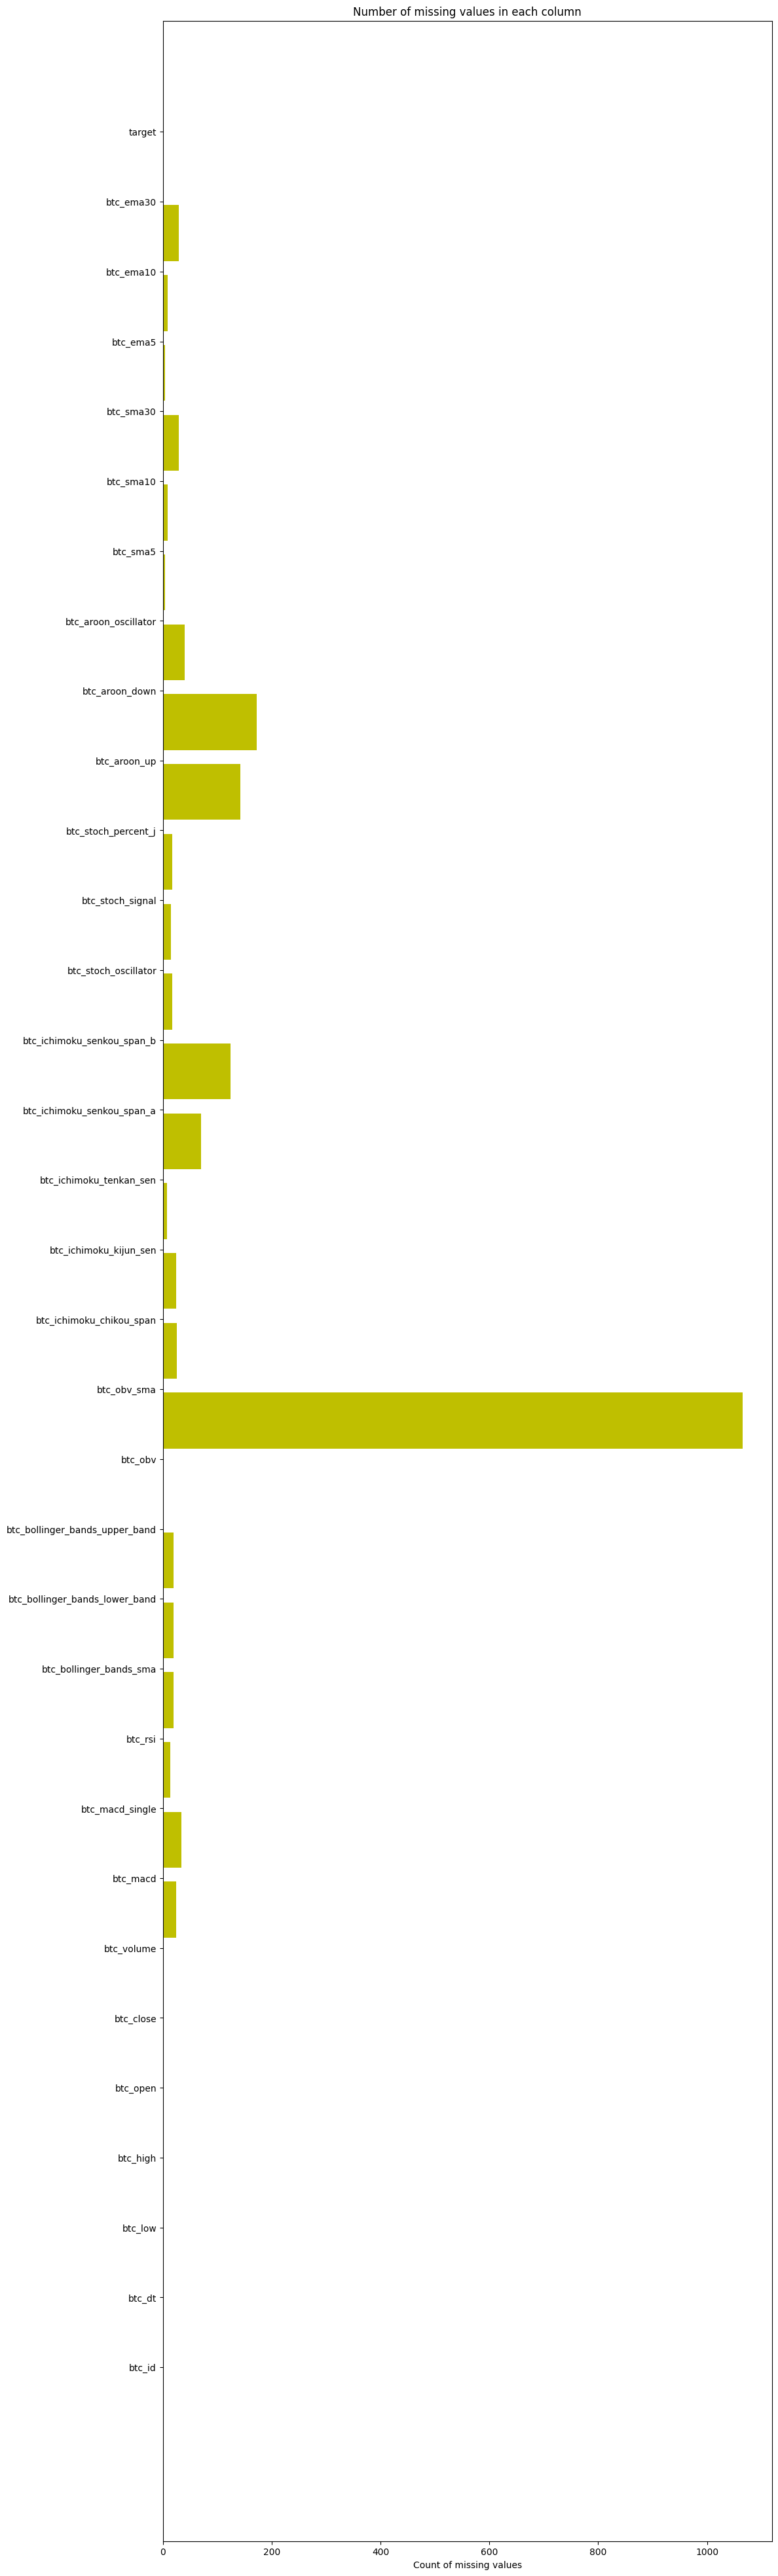

In [7]:
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,50))
rects = ax.barh(ind, np.array(values), color='y')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
#autolabel(rects)
plt.show()

The number of NaN value of btc_obv_sma colum is 1065 which is the same number of all records in the dataset.
So, let's remove the column from the dataset.

In [8]:
df = btc_df_with_target.drop(['btc_obv_sma'],axis=1)
if "btc_obv_sma" not in df.columns:
    print("btc_obv_sma column is deleted.")
else:
    print("Error. Failed to delete btc_obv_sma column.")

btc_obv_sma column is deleted.


Check the distribution plot for some of the columns

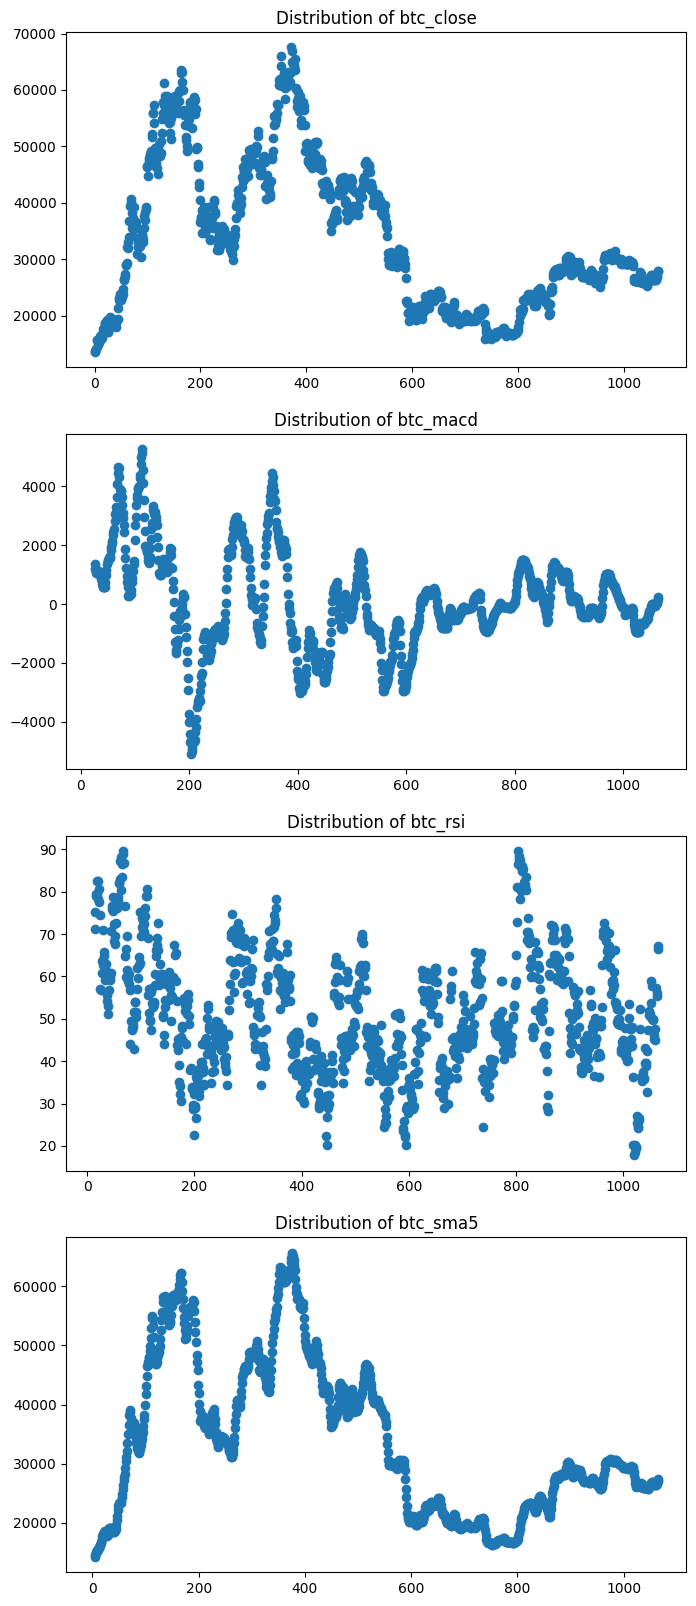

In [9]:
cols_to_use = ['btc_close', 'btc_macd', 'btc_rsi', 'btc_sma5']
fig = plt.figure(figsize=(8, 20))
plot_count = 0
for col in cols_to_use:
    plot_count += 1
    plt.subplot(4, 1, plot_count)
    plt.scatter(range(df.shape[0]), df[col].values)
    plt.title("Distribution of "+col)
plt.show()

Plot the distribution of the target value.

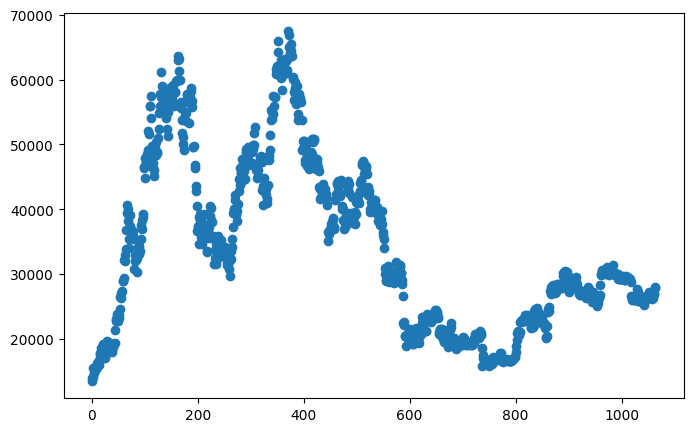

In [10]:
plt.figure(figsize=(8, 5))
plt.scatter(range(df.shape[0]), df.target.values)
plt.show()